In [1]:
from config import *
from utils.db_connection import create_connection, query_data, query_sql_file, select_table
from src.data import process_vital_signs, process_diagnoses, process_pain, process_labs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to MIMIC-III database
con = create_connection()

In [4]:
script = query_sql_file(os.path.join(SCRIPTS_LAB_RESULTS_DIR, 'labs_first_day.sql'), con)
query = script[0]

labs = query_data(query, con)
labs.head()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bands_min,bands_max,bicarbonate_min,...,inr_min,inr_max,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max
0,2,163353,243653,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,22.0
1,3,145834,211552,15.0,23.0,1.8,1.8,2.0,5.0,11.0,...,1.3,1.7,13.5,15.7,136.0,153.0,41.0,53.0,11.3,24.4
2,4,185777,294638,15.0,15.0,2.8,2.8,NaN,NaN,21.0,...,1.1,1.1,12.8,12.8,141.0,141.0,10.0,10.0,9.7,9.7
3,5,178980,214757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.9,13.9
4,6,107064,228232,20.0,23.0,3.0,3.0,NaN,NaN,15.0,...,1.0,1.4,12.6,14.6,134.0,138.0,62.0,65.0,10.6,10.6


In [5]:
labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject_id       61532 non-null  int64  
 1   hadm_id          61532 non-null  int64  
 2   icustay_id       61532 non-null  int64  
 3   aniongap_min     53678 non-null  float64
 4   aniongap_max     53678 non-null  float64
 5   albumin_min      19325 non-null  float64
 6   albumin_max      19325 non-null  float64
 7   bands_min        10006 non-null  float64
 8   bands_max        10006 non-null  float64
 9   bicarbonate_min  54411 non-null  float64
 10  bicarbonate_max  54411 non-null  float64
 11  bilirubin_min    26106 non-null  float64
 12  bilirubin_max    26106 non-null  float64
 13  creatinine_min   52900 non-null  float64
 14  creatinine_max   52900 non-null  float64
 15  chloride_min     54669 non-null  float64
 16  chloride_max     54669 non-null  float64
 17  glucose_min 

In [6]:
# Reconstruct the dataframe
#  melt the df to get all the lab tests in one column and their values in another
df_melted = labs.melt(id_vars=['subject_id', 'hadm_id', 'icustay_id'], var_name='label', value_name='value')

# label column now contains entries like 'aniongap_min', 'aniongap_max'
# split this into two columns: one for the lab test and one for 'min' or 'max'.
df_melted['min_max'] = df_melted['label'].str[-3:]
df_melted['label'] = df_melted['label'].str[:-4]

# Now we pivot the DataFrame to get the min and max values in separate columns for each lab test.
df_pivot = df_melted.pivot_table(index=['subject_id', 'hadm_id', 'icustay_id', 'label'], columns='min_max', values='value').reset_index()

df_pivot.rename(columns={"min": "min_value", "max": "max_value"}, inplace=True)
df_pivot.head()

min_max,subject_id,hadm_id,icustay_id,label,max_value,min_value
0,2,163353,243653,bands,1.0,1.0
1,2,163353,243653,hematocrit,49.6,49.6
2,2,163353,243653,hemoglobin,16.5,16.5
3,2,163353,243653,platelet,302.0,5.0
4,2,163353,243653,wbc,22.0,0.1


In [7]:
# Assign a category to each label
df_pivot['category'] = df_pivot['label'].apply(process_labs.define_lab_category)
df_pivot.head()

min_max,subject_id,hadm_id,icustay_id,label,max_value,min_value,category
0,2,163353,243653,bands,1.0,1.0,White Blood Cells
1,2,163353,243653,hematocrit,49.6,49.6,Red Blood Cells
2,2,163353,243653,hemoglobin,16.5,16.5,Red Blood Cells
3,2,163353,243653,platelet,302.0,5.0,Platelets
4,2,163353,243653,wbc,22.0,0.1,White Blood Cells


In [8]:
query = \
"""
SELECT hadm_id, hospital_expire_flag
FROM admissions;
"""
admissions = query_data(query, con)
df_pivot = pd.merge(df_pivot, admissions, on=['hadm_id'], how='left')
df_pivot.head()

,subject_id,hadm_id,icustay_id,label,max_value,min_value,category,hospital_expire_flag
0,2,163353,243653,bands,1.0,1.0,White Blood Cells,0
1,2,163353,243653,hematocrit,49.6,49.6,Red Blood Cells,0
2,2,163353,243653,hemoglobin,16.5,16.5,Red Blood Cells,0
3,2,163353,243653,platelet,302.0,5.0,Platelets,0
4,2,163353,243653,wbc,22.0,0.1,White Blood Cells,0


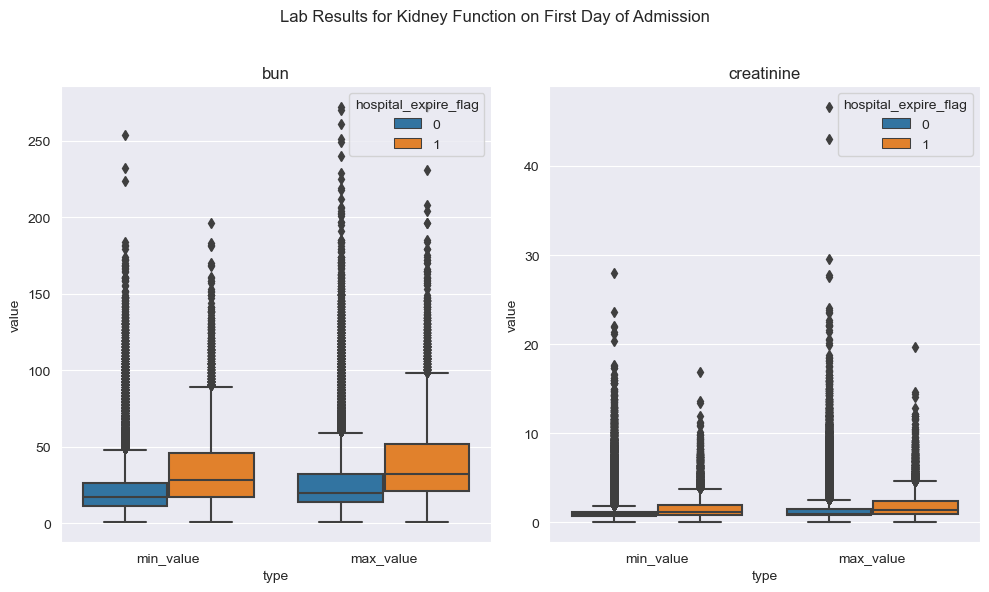

In [9]:
categories = list(process_labs.lab_categories.keys())

process_labs.visualize_category(df_pivot, category=categories[0])

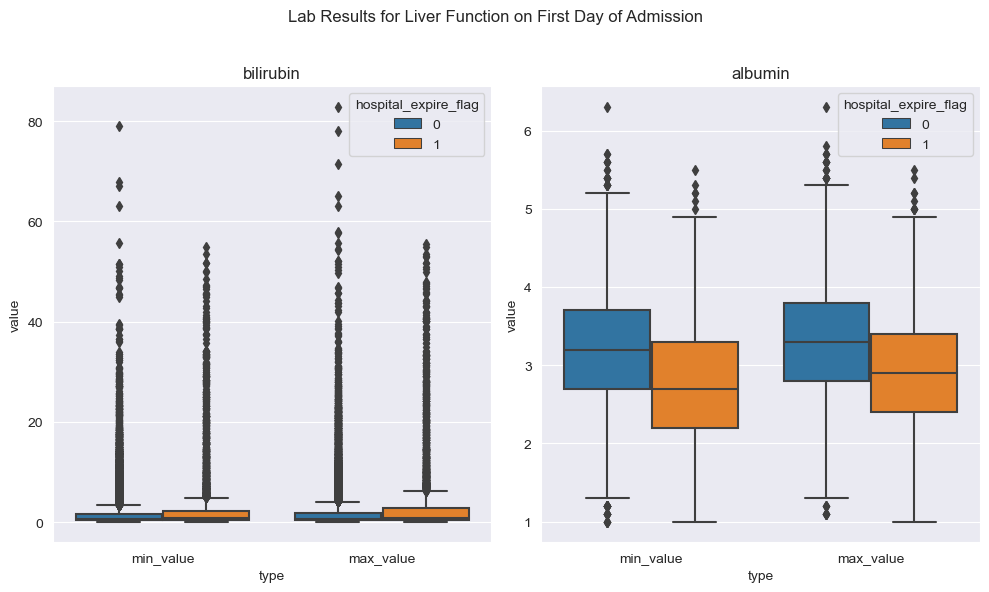

In [10]:
process_labs.visualize_category(df_pivot, category=categories[1])

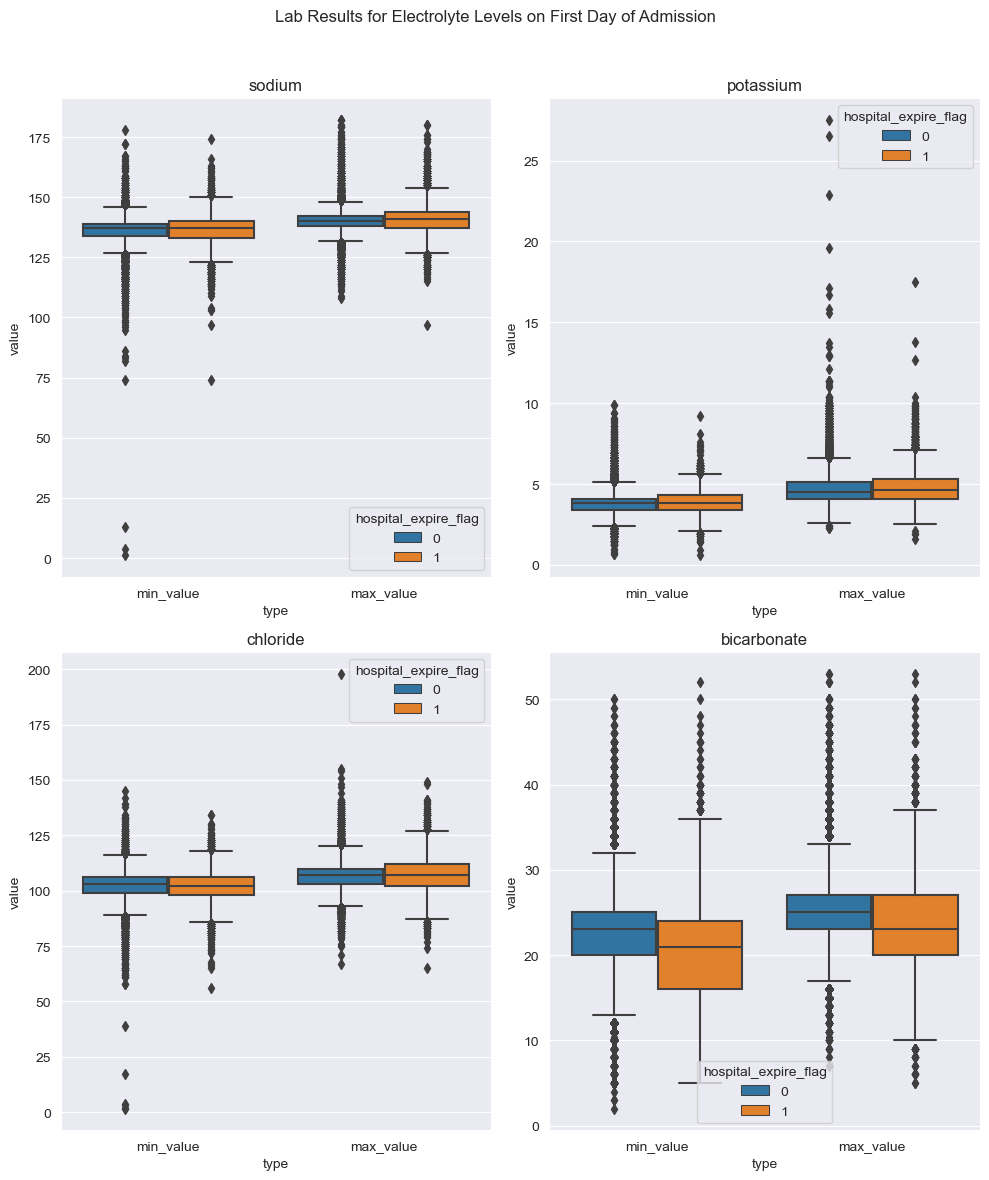

In [11]:
process_labs.visualize_category(df_pivot, category=categories[2])

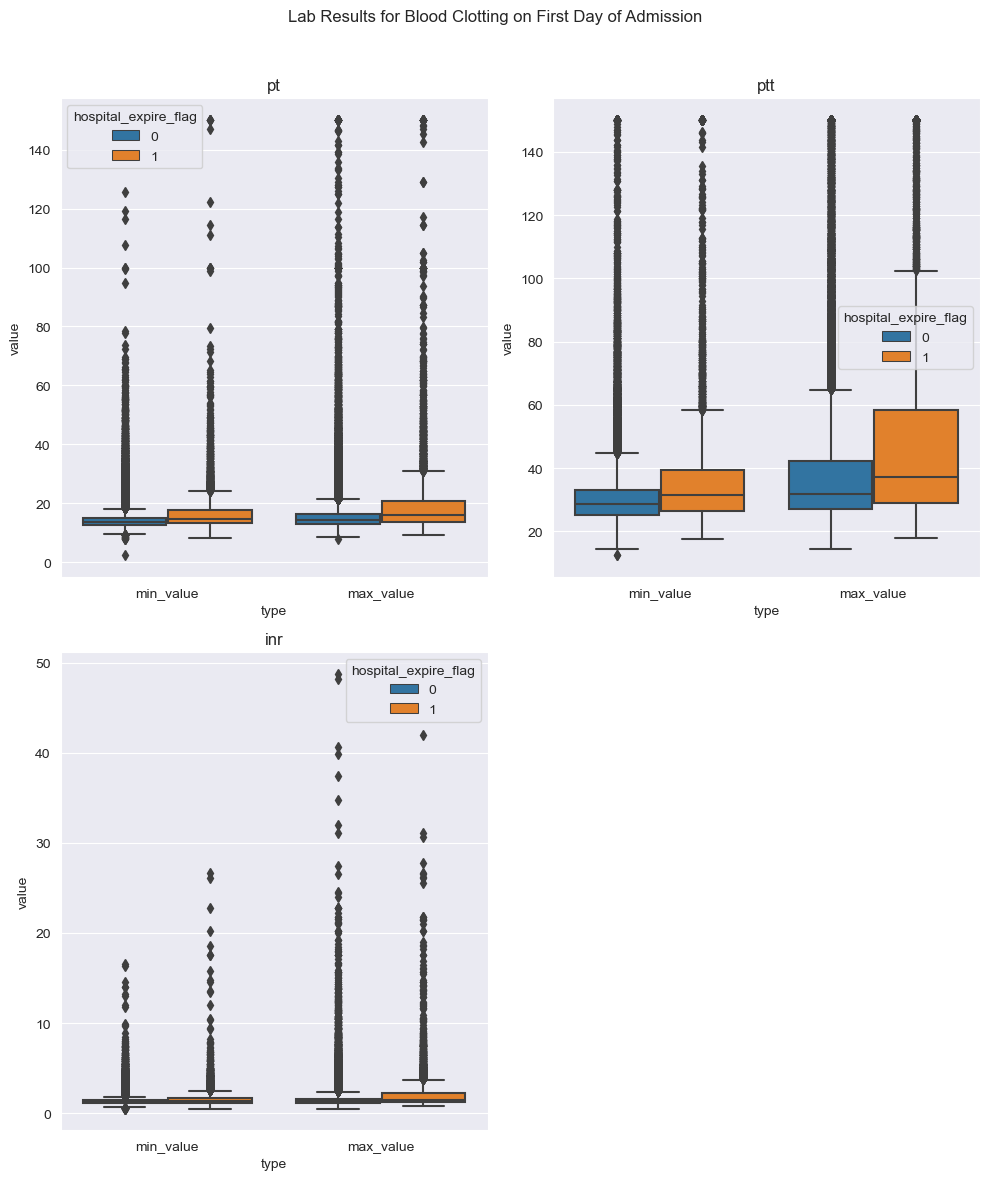

In [12]:
process_labs.visualize_category(df_pivot, category=categories[3])

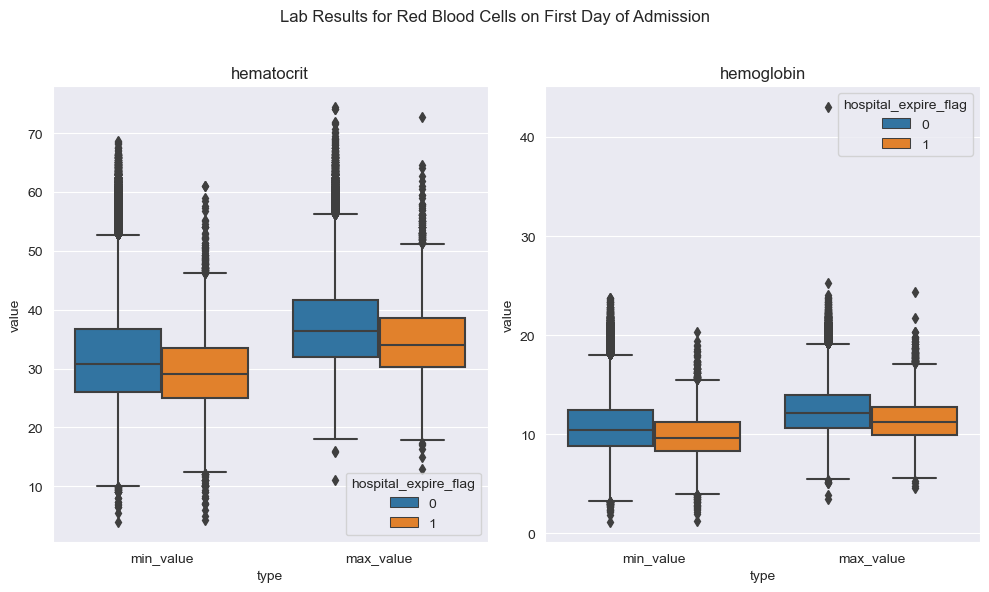

In [13]:
process_labs.visualize_category(df_pivot, category=categories[4])

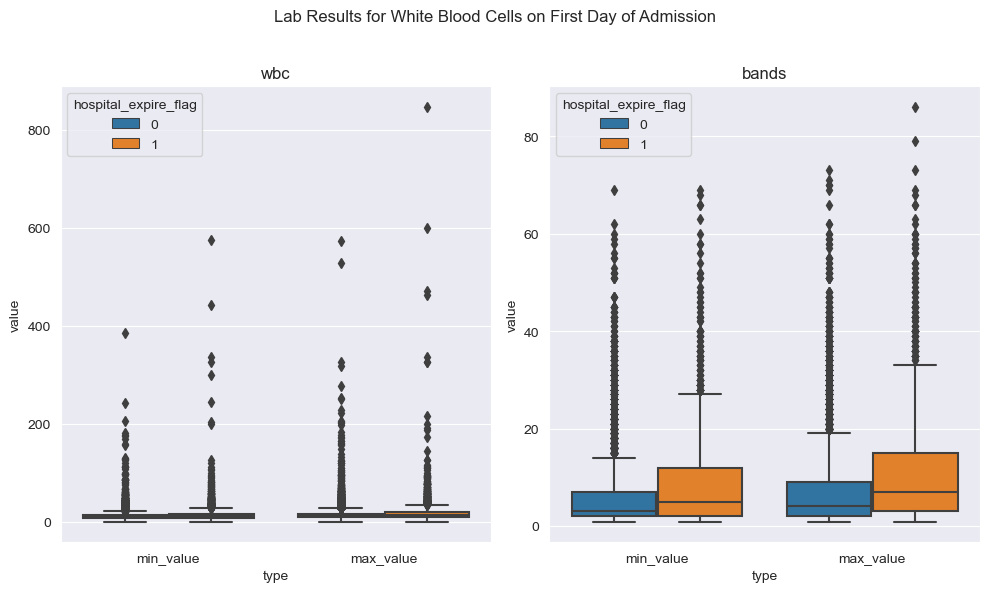

In [14]:
process_labs.visualize_category(df_pivot, category=categories[5])

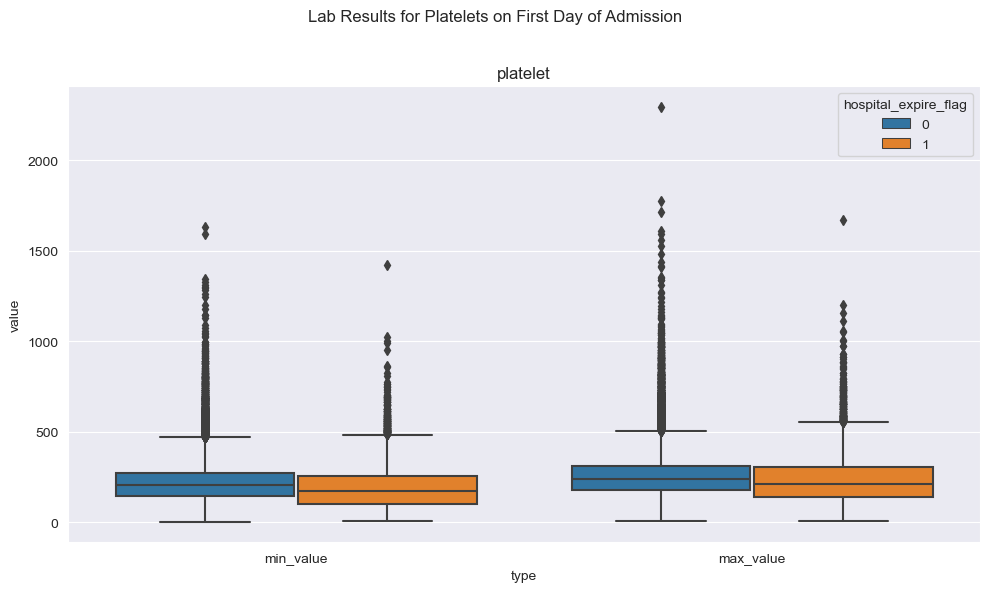

In [15]:
df = df_pivot
category = categories[6]
lab_categories = process_labs.lab_categories

df_filtered = df[df['category'] == category]
lab_tests = lab_categories[category]

nrows = 1
ncols = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 6))
axes = [axes]  # Wrap the single axis in a list to maintain compatibility with the loop
fig.suptitle(f'Lab Results for {category} on First Day of Admission')

for i, lab_test in enumerate(lab_tests):
    df_lab_test = df_filtered[df_filtered['label'] == lab_test]
    df_melted = df_lab_test.melt(id_vars=['subject_id', 'hadm_id', 'icustay_id', 'label', 'hospital_expire_flag'],
                                 value_vars=['min_value', 'max_value'],
                                 var_name='type', value_name='value')

    sns.boxplot(data=df_melted, x='type', y='value', hue='hospital_expire_flag', ax=axes[i])
    axes[i].set_title(lab_test)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(FIG_LAB_RESULTS_DIR, f'6_{category}.png'))
plt.show()

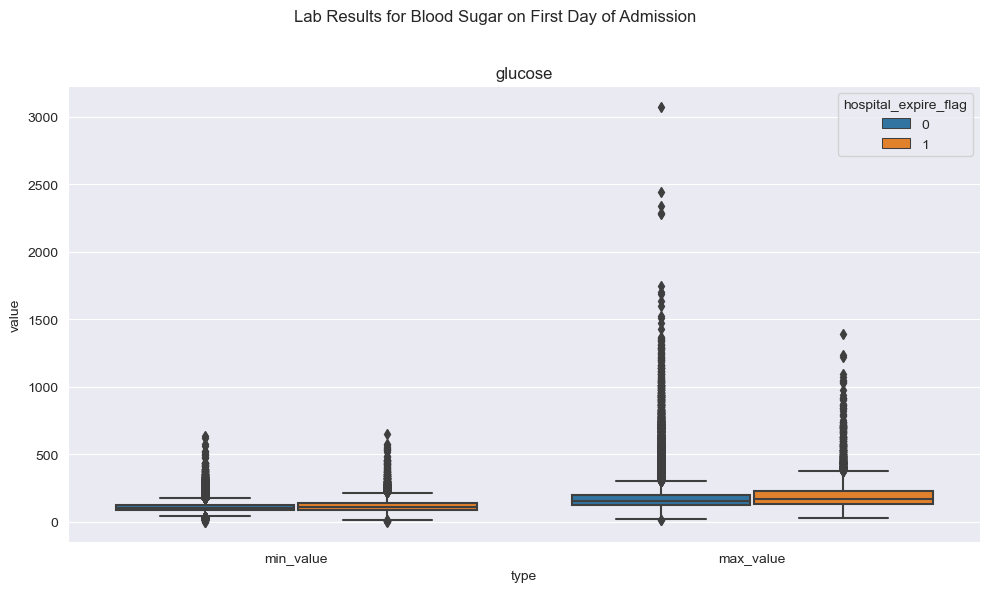

In [16]:
df = df_pivot
category = categories[7]

df_filtered = df[df['category'] == category]
lab_tests = lab_categories[category]

nrows = 1
ncols = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 6))
axes = [axes]  # Wrap the single axis in a list to maintain compatibility with the loop
fig.suptitle(f'Lab Results for {category} on First Day of Admission')

for i, lab_test in enumerate(lab_tests):
    df_lab_test = df_filtered[df_filtered['label'] == lab_test]
    df_melted = df_lab_test.melt(id_vars=['subject_id', 'hadm_id', 'icustay_id', 'label', 'hospital_expire_flag'],
                                 value_vars=['min_value', 'max_value'],
                                 var_name='type', value_name='value')

    sns.boxplot(data=df_melted, x='type', y='value', hue='hospital_expire_flag', ax=axes[i])
    axes[i].set_title(lab_test)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(FIG_LAB_RESULTS_DIR, f'7_{category}.png'))
plt.show()

In [17]:
df_pivot.to_csv(os.path.join(PROCESSED_DATA_DIR, 'lab_results_first_day.csv'))